In [1]:
!python --version

import os

print(f"Number of CPU cores available: {os.cpu_count()}")

Python 3.12.12
Number of CPU cores available: 12


**DATASET ACQUISITION**

In [2]:
import kagglehub

mlg_ulb_creditcardfraud_path = kagglehub.dataset_download('mlg-ulb/creditcardfraud')

print('Data source import complete.')

Data source import complete.


**DATA LOADING & FEATURE ENGINEERING**

In [3]:
import os
import pandas as pd
import numpy as np

# Load dataset into memory
data_path = os.path.join(mlg_ulb_creditcardfraud_path, 'creditcard.csv')
df = pd.read_csv(data_path)

# Convert 'Time' into 'Time of Day' (0 to 24 hours)
df['SecondsInDay'] = df['Time'] % 86400

# Create a 'Density' feature to see how much money is spent per second
df['TransactionDensity'] = df['Amount'] / (df['SecondsInDay'] + 1)

# Fill any empty gaps in the data with the average value of the column
df.fillna(df.mean(numeric_only=True), inplace=True)

# These two features need to be scaled later
features_to_scale_names = ['Amount', 'TransactionDensity']

pca_features = [f'V{i}' for i in range(1, 29)]

X = df[features_to_scale_names + pca_features].copy()
y = df['Class']

print(f"Full dataset ready for splitting. Total records: {len(df)}")
print(f"Fraud ratio: {y.mean():.4%}")
print(f"Fraud cases: {y.sum()}")

Full dataset ready for splitting. Total records: 284807
Fraud ratio: 0.1727%
Fraud cases: 492


**DATA VISUALIZATION**

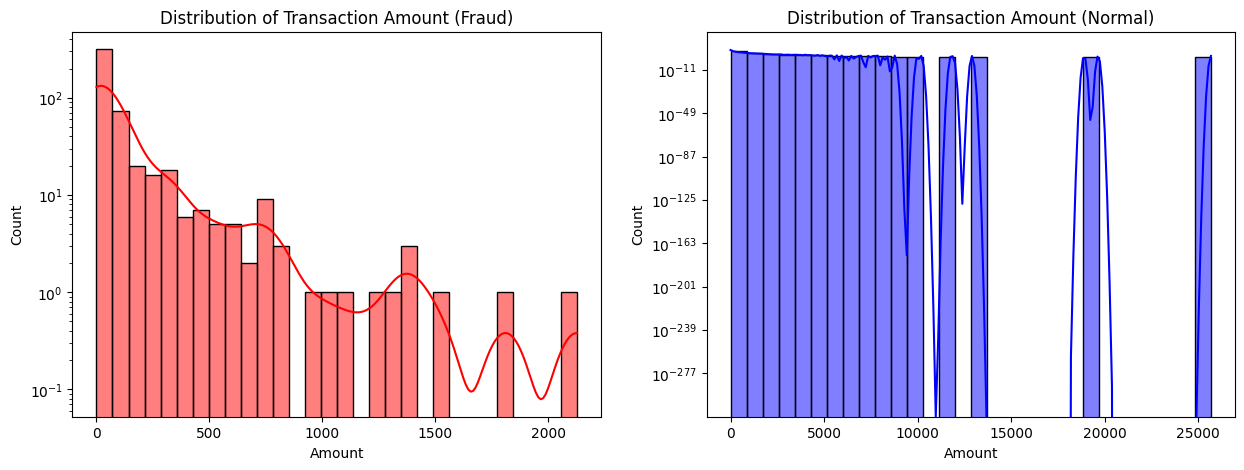

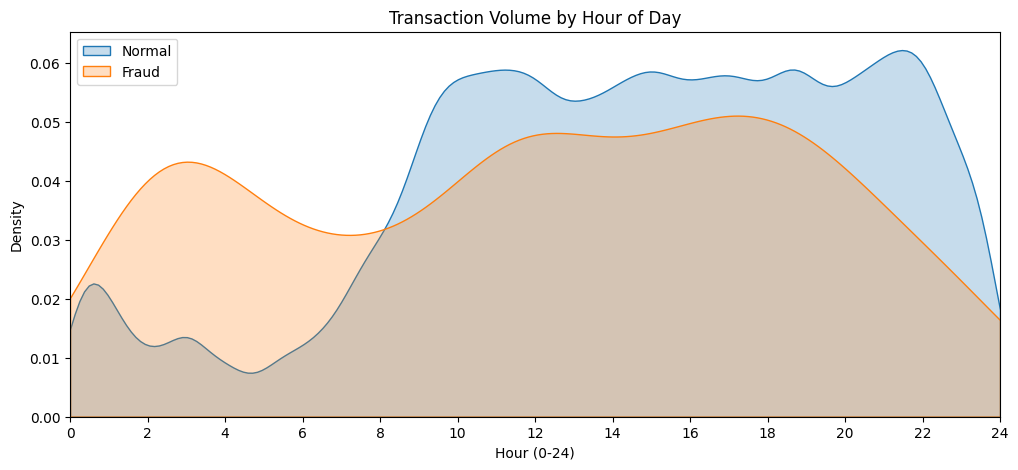

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Distribution of Amount for Fraud
sns.histplot(df[df['Class'] == 1]['Amount'], bins=30, ax=ax1, kde=True, color='red')
ax1.set_title('Distribution of Transaction Amount (Fraud)')
ax1.set_yscale('log') # Log scale because amounts vary wildly

# Distribution of Amount for Normal
sns.histplot(df[df['Class'] == 0]['Amount'], bins=30, ax=ax2, kde=True, color='blue')
ax2.set_title('Distribution of Transaction Amount (Normal)')
ax2.set_yscale('log')

plt.show()

# Convert the raw 'Time' (seconds) into a 24-hour format
df['Hour'] = (df['Time'] / 3600) % 24

plt.figure(figsize=(12, 5))
sns.kdeplot(df[df['Class'] == 0]['Hour'], label='Normal', fill=True, clip=(0, 24))
sns.kdeplot(df[df['Class'] == 1]['Hour'], label='Fraud', fill=True, clip=(0, 24))
plt.title('Transaction Volume by Hour of Day')
plt.xlabel('Hour (0-24)')
plt.xlim(0, 24)
plt.xticks(range(0, 25, 2)) # Set markers every 2 hours for better readability
plt.legend()
plt.show()

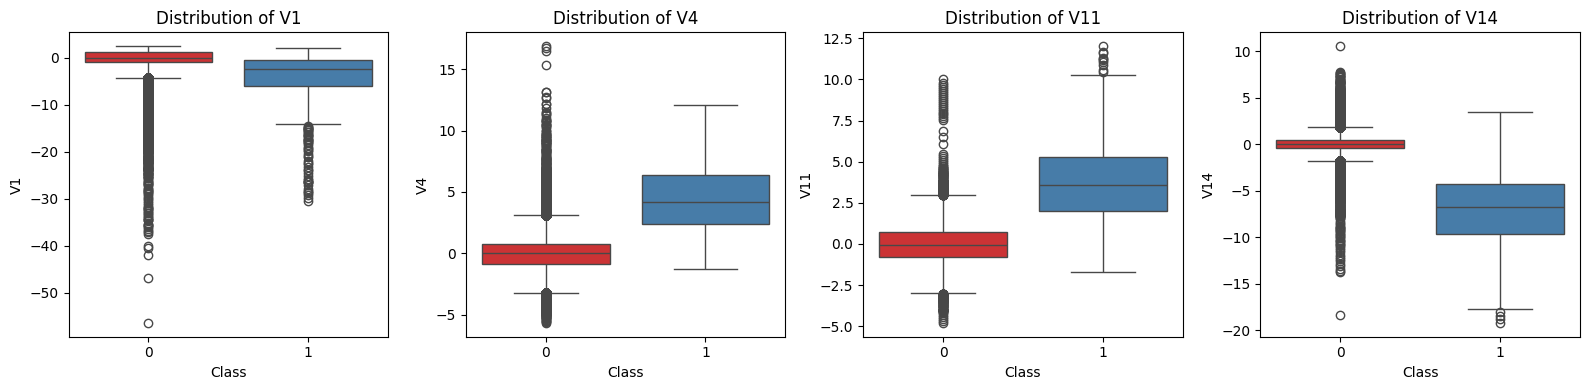

In [5]:
selected_features = ['V1', 'V4', 'V11', 'V14']

plt.figure(figsize=(16, 4))
for i, col in enumerate(selected_features):
    plt.subplot(1, 4, i+1)
    sns.boxplot(x='Class', y=col, data=df, hue='Class', palette="Set1", legend=False)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

**Feature Correlation**

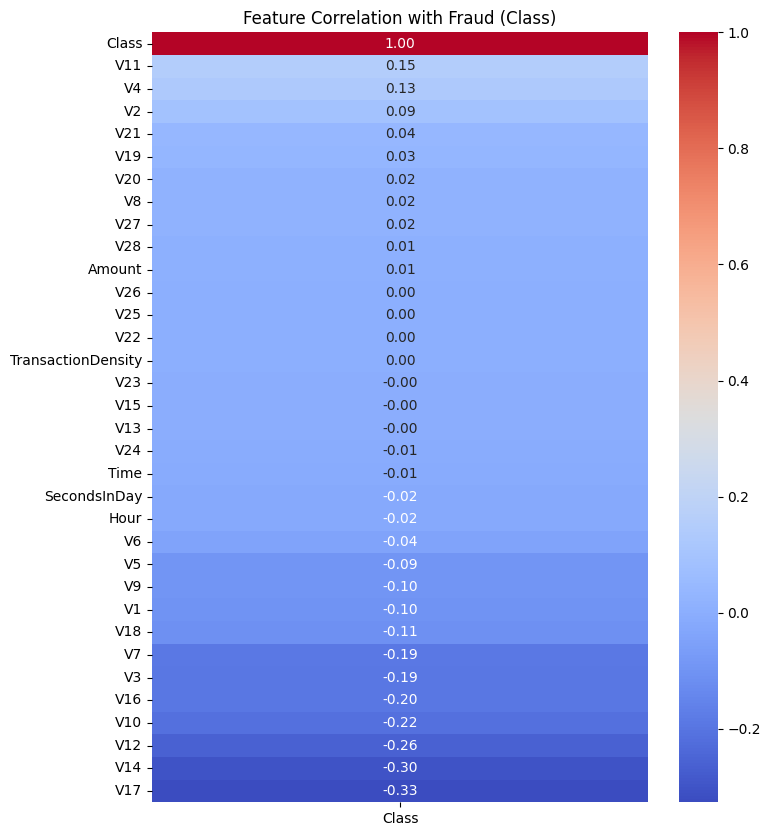

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))

corr = df.corr()[['Class']].sort_values(by='Class', ascending=False)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation with Fraud (Class)')
plt.show()

**ISOLATION FOREST**


In [7]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

clean_features = ['Amount', 'TransactionDensity'] + [f'V{i}' for i in range(1, 29)]

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scaling the dataset
scaler = StandardScaler()
scaler.fit(X_train[features_to_scale_names])
X_train[features_to_scale_names] = scaler.transform(X_train[features_to_scale_names])
X_test[features_to_scale_names] = scaler.transform(X_test[features_to_scale_names])

# Isolation Forest
iforest = IsolationForest(contamination=0.01, random_state=42) # contamination='auto' leads to 3.83% outliers
X_train['isOutlier'] = iforest.fit_predict(X_train[clean_features])
X_test['isOutlier'] = iforest.predict(X_test[clean_features])

print("Total Anomaly Counts:")
print(X_train['isOutlier'].value_counts())
print(f"Features used for Outlier Detection: {len(clean_features)}")

Total Anomaly Counts:
isOutlier
 1    197370
-1      1994
Name: count, dtype: int64
Features used for Outlier Detection: 30


**RANDOM UNDERSAMPLING**


In [8]:
from imblearn.under_sampling import RandomUnderSampler

# sampling_strategy=0.1 means fraud cases represent 10% of the training data
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(f"Training set size (Balanced): {len(X_train_rus)}")
print(f"Test set size (Real World): {len(X_test)}")
print(f"Fraud Percentage in training data (RUS): {y_train_rus.mean():.4%}")

Training set size (Balanced): 3784
Test set size (Real World): 85443
Fraud Percentage in training data (RUS): 9.0909%


***SMOTE***

In [9]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Define the target size for the majority class
target_size = 10000

# Undersample 'Normal' class to 10,000
rus = RandomUnderSampler(sampling_strategy={0: target_size}, random_state=42)
X_temp, y_temp = rus.fit_resample(X_train, y_train)

# SMOTE 'Fraud' class
# sampling_strategy=1.0 creates a perfect 50/50 balance between the classes
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_temp, y_temp)

print(f"Original Training Fraud Count: {y_train.value_counts()[1]}")
print(f"New Training Set Size: {len(X_train_smote)}")
print(f"New Fraud Count: {sum(y_train_smote == 1)}")
print(f"New Normal Count: {sum(y_train_smote == 0)}")
print(f"Fraud Percentage in training data: {y_train_smote.mean():.4%}")

Original Training Fraud Count: 344
New Training Set Size: 20000
New Fraud Count: 10000
New Normal Count: 10000
Fraud Percentage in training data: 50.0000%


**DATA INTEGRITY CHECK**

In [10]:
# Create a summary for both Columns (Features) and Rows (Samples)
verification_data = [
    ("Initial", X_train, y_train),
    ("RUS",     X_train_rus, y_train_rus),
    ("SMOTE",   X_train_smote, y_train_smote),
    ("Test",    X_test, y_test)
]

print(f"{'Dataset':<10} | {'Features':<10} | {'Samples':<10} | {'Match?'}")
print("-" * 50)

for name, x_df, y_ser in verification_data:
    features = x_df.shape[1]
    samples_x = x_df.shape[0]
    samples_y = len(y_ser)
    match = "YES" if samples_x == samples_y else "NO"
    
    print(f"{name:<10} | {features:<10} | {samples_x:<10} | {match}")
    
    # Assert that X and y rows always match
    assert samples_x == samples_y, f"Row mismatch in {name} set!"

# Final check that all X datasets have the same number of features (31)
assert len(set(d[1].shape[1] for d in verification_data)) == 1, "!Feature count mismatch!"

print("\nAll row and column counts are verified. Ready to train!")

Dataset    | Features   | Samples    | Match?
--------------------------------------------------
Initial    | 31         | 199364     | YES
RUS        | 31         | 3784       | YES
SMOTE      | 31         | 20000      | YES
Test       | 31         | 85443      | YES

All row and column counts are verified. Ready to train!


**Logistic regression etc.**

In [11]:
import time
import pandas as pd
from sklearn.metrics import recall_score, average_precision_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

performance_data = []

print(f"{'Model':<25} | {'Rec':<6} | {'Prec':<6} | {'F1':<6} | {'AUPRC':<6} | {'Train(s)':<8}| {'Inf(ms)':<8}")
print("-" * 80)

def record_performance(name, model, X_train, y_train, X_test, y_test):
    # Training duration counter
    start_train = time.perf_counter()
    model.fit(X_train, y_train)
    train_time = time.perf_counter() - start_train

    # Inference duration counter
    start_inf = time.perf_counter()
    
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    inf_time = (time.perf_counter() - start_inf)

    y_pred = (y_scores > (0.5 if hasattr(model, "predict_proba") else 0)).astype(int)
    
    inf_time_ms = (inf_time / len(X_test)) * 1000

    # Classification metrics
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0) 
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auprc = average_precision_score(y_test, y_scores)

    print(f"{name:<25} | {rec:.3f}  | {prec:.3f}  | {f1:.3f}  | {auprc:.3f}  | {train_time:.2f} | {inf_time_ms:<8.6f}")

    return {
        "Model": name,
        "Recall": rec,
        "Precision": prec,
        "F1-Score": f1,
        "AUPRC": auprc,
        "Train Time (s)": train_time,
        "Inference Time (ms)": inf_time_ms
    }

# Initialize list of classifiers with default hyperparameters
models = [
    ("Logistic Regression", LogisticRegression(solver='liblinear', random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("XGBoost", XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, eval_metric='logloss')),
    ("LightGBM", LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbosity=-1)),
    ("Linear SVC", LinearSVC(C=1, random_state=42, dual=False))
]

# Run for initial dataset + IF
print("RESULTS INITIAL + IF")
for name, model in models:
    res = record_performance(f"{name} (IF)", model, X_train, y_train, X_test, y_test)
    performance_data.append(res)

print("-" * 80)

# Run for RUS + IF
print("RESULTS RUS")
for name, model in models:
    res = record_performance(f"{name} (RUS)", model, X_train_rus, y_train_rus, X_test, y_test)
    performance_data.append(res)

print("-" * 80)

# Run for RUS + SMOTE + IF
print("RESULTS SMOTE")
for name, model in models:
    res = record_performance(f"{name} (SMOTE)", model, X_train_smote, y_train_smote, X_test, y_test)
    performance_data.append(res)

Model                     | Rec    | Prec   | F1     | AUPRC  | Train(s)| Inf(ms) 
--------------------------------------------------------------------------------
RESULTS INITIAL + IF
Logistic Regression (IF)  | 0.622  | 0.852  | 0.719  | 0.710  | 2.08 | 0.000158
Decision Tree (IF)        | 0.723  | 0.781  | 0.751  | 0.565  | 13.72 | 0.000182
Random Forest (IF)        | 0.757  | 0.974  | 0.852  | 0.823  | 25.89 | 0.001534
Gradient Boosting (IF)    | 0.162  | 0.727  | 0.265  | 0.186  | 234.54 | 0.001580
XGBoost (IF)              | 0.736  | 0.932  | 0.823  | 0.783  | 1.01 | 0.000383
LightGBM (IF)             | 0.459  | 0.276  | 0.345  | 0.178  | 1.14 | 0.000861
Linear SVC (IF)           | 0.581  | 0.860  | 0.694  | 0.718  | 1.46 | 0.000151
--------------------------------------------------------------------------------
RESULTS RUS
Logistic Regression (RUS) | 0.831  | 0.376  | 0.518  | 0.658  | 0.02 | 0.000138
Decision Tree (RUS)       | 0.831  | 0.089  | 0.161  | 0.075  | 0.12 | 0.00018

***BALANCED RANDOM FOREST***

In [12]:
from imblearn.ensemble import BalancedRandomForestClassifier

# This model balances each bootstrap sample internally during training
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    random_state=42,
    sampling_strategy='all',
    replacement=True,
    n_jobs=-1
)

res = record_performance("Balanced RF + IF", brf, X_train, y_train, X_test, y_test)
performance_data.append(res)

Balanced RF + IF          | 0.845  | 0.121  | 0.212  | 0.724  | 2.37 | 0.001538


In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras import metrics
import time
from sklearn.metrics import recall_score, precision_score, f1_score, average_precision_score

def record_nn_performance(name, X_train_data, y_train_data, X_test, y_test):
    # Define the Neural Network Architecture
    model = Sequential([
        Input(shape=(X_train_data.shape[1],)),
        
        Dense(64, activation='relu'),
        Dropout(0.2), 

        Dense(32, activation='relu'),
        Dropout(0.1),
        
        Dense(1, activation='sigmoid')
    ])

    # Compile the model focusing on AUPRC
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[metrics.AUC(name='auprc', curve='PR')]
    )

    # Early stopping prevents wasted compute
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='auprc', 
        patience=1, 
        restore_best_weights=True,
        mode='max'
    )

    # Adjust batch size based on the dataset size
    current_batch_size = 32 if len(X_train_data) < 5000 else 128
    
    start_train = time.perf_counter()
    model.fit(
        X_train_data, y_train_data, 
        epochs=30, 
        batch_size=current_batch_size, 
        verbose=0,
        callbacks=[early_stop]
    )
    train_time = time.perf_counter() - start_train

    start_inf = time.perf_counter()
    y_probs = model.predict(X_test, verbose=0).flatten()
    inf_duration = time.perf_counter() - start_inf
    
    y_pred = (y_probs > 0.5).astype('int32')
    inf_time_ms = (inf_duration / len(X_test)) * 1000

    # Calculate classification metrics
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auprc = average_precision_score(y_test, y_probs)

    print(f"{name:<30} | {rec:.3f} | {prec:.3f} | {f1:.3f} | {auprc:.3f} | {train_time:<8.2f} | {inf_time_ms:.6f}")

    return {
        "Model": name,
        "Recall": rec,
        "Precision": prec,
        "F1-Score": f1,
        "AUPRC": auprc,
        "Train Time (s)": train_time,
        "Inference Time (ms)": inf_time_ms
    }

res_nn_initial = record_nn_performance("Neural Network (IF)", X_train, y_train, X_test, y_test)
performance_data.append(res_nn_initial)

res_nn_rus = record_nn_performance("Neural Network (RUS)", X_train_rus, y_train_rus, X_test, y_test)
performance_data.append(res_nn_rus)

res_nn_smote = record_nn_performance("Neural Network (SMOTE)", X_train_smote, y_train_smote, X_test, y_test)
performance_data.append(res_nn_smote)

Neural Network (IF)            | 0.791 | 0.818 | 0.804 | 0.814 | 25.36    | 0.034900
Neural Network (RUS)           | 0.831 | 0.446 | 0.580 | 0.672 | 3.45     | 0.033274
Neural Network (SMOTE)         | 0.858 | 0.114 | 0.201 | 0.696 | 4.88     | 0.032617


In [14]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

# Define the steps (RUS -> SMOTE -> Classifier)
pipeline = ImbPipeline([
    ('rus', RandomUnderSampler(sampling_strategy={0: 10000}, random_state=42)),
    ('smote', SMOTE(sampling_strategy=1.0, random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameters to test
param_grid = {
    'classifier__n_estimators': [10, 50, 100],
    'classifier__max_depth': [5, 10, 15]
}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='average_precision', 
    n_jobs=-1
)

# 3. Fit using the original X_train
grid_search.fit(X_train, y_train) 

print("Grid Search Complete.")
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Best CV AUPRC Score: {grid_search.best_score_:.4f}")

# Record performance using the pipeline
best_rf_model = grid_search.best_estimator_

res_grid = record_performance("RF (Tuned via Pipeline)", best_rf_model, X_train, y_train, X_test, y_test)
performance_data.append(res_grid)

Grid Search Complete.
Best Hyperparameters: {'classifier__max_depth': 15, 'classifier__n_estimators': 100}
Best CV AUPRC Score: 0.7818
RF (Tuned via Pipeline)   | 0.845  | 0.427  | 0.567  | 0.706  | 5.18 | 0.007011


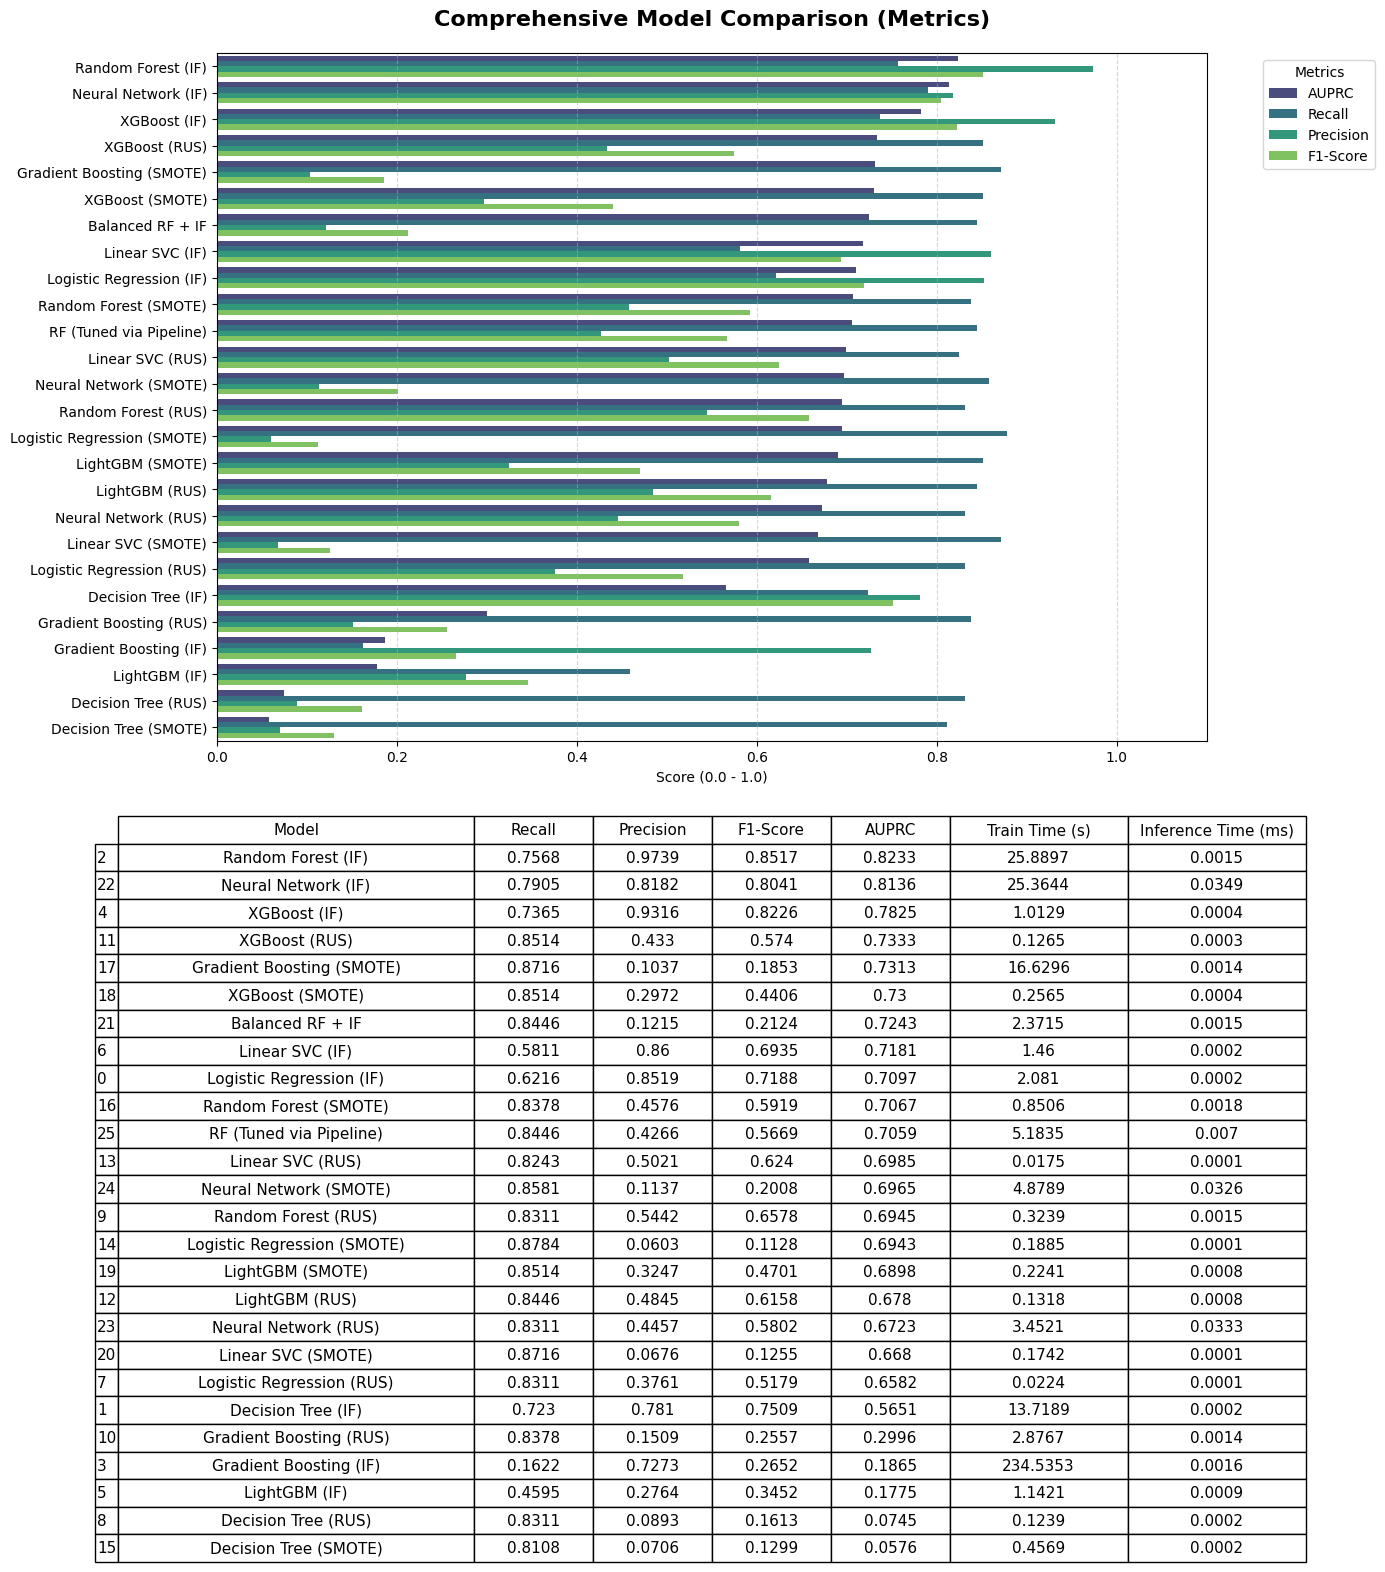

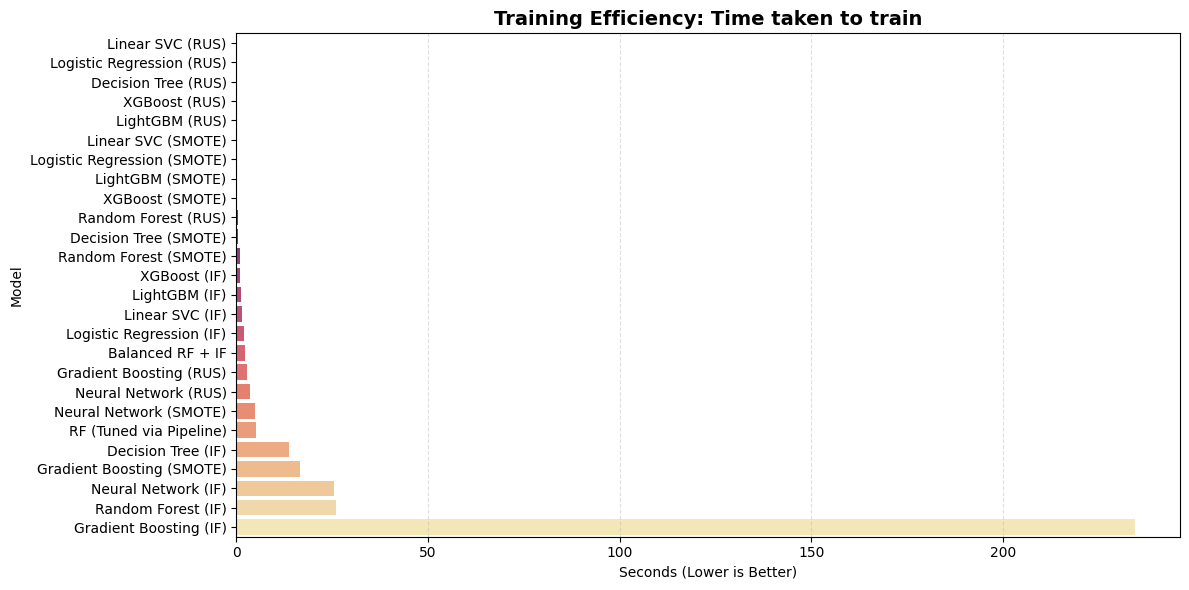

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import table

df_results = pd.DataFrame(performance_data).sort_values(by='AUPRC', ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16), gridspec_kw={'height_ratios': [2, 1]})

df_melted = df_results.melt(id_vars='Model', value_vars=['AUPRC', 'Recall', 'Precision', 'F1-Score'])

sns.barplot(data=df_melted, y='Model', x='value', hue='variable', ax=ax1, palette='viridis')
ax1.set_title('Comprehensive Model Comparison (Metrics)', fontsize=16, weight='bold', pad=20)
ax1.set_xlabel('Score (0.0 - 1.0)')
ax1.set_ylabel('')
ax1.set_xlim(0, 1.1)
ax1.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis='x', linestyle='--', alpha=0.5)

ax2.axis('off') 
tbl = table(ax2, df_results.round(4), loc='center', cellLoc='center', colWidths=[0.3, 0.1, 0.1, 0.1, 0.1, 0.15, 0.15])
tbl.auto_set_font_size(False)
tbl.set_fontsize(11)
tbl.scale(1.2, 1.8)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_results.sort_values('Train Time (s)'), y='Model', x='Train Time (s)', palette='magma', hue='Model', legend=False)
plt.title('Training Efficiency: Time taken to train', fontsize=14, weight='bold')
plt.xlabel('Seconds (Lower is Better)')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()